In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeClassifier

In [3]:
# load dataset
df = pd.read_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_DataFinal.csv'")

In [4]:
#set index to unnamed
df.drop("Unnamed: 0", axis= 1, inplace= True)

## Create Sparse Dataframe
* Data is far to large to convert into normal dataframe
* Requires creation of a sparse pivot, authors for rows, subreddits for columns & number of posts as variable

In [5]:
# creating unique list of subreddits with target as the last value for ease of data manipulation
unique_subs = list(df["subreddit"].unique())
unique_subs.remove("df_target")
unique_subs.append("df_target")

In [6]:
# data is to large for a pandas pivot table, creating a function to create a sparse version 

def create_sparse_pivot(rows, cols, data, values):
    ### function creates a sparse pivot table from large datasets
    r = CategoricalDtype(sorted(data[rows].unique()), ordered=True)
    c = CategoricalDtype(unique_subs)

    row = data[rows].astype(r).cat.codes
    col = data[cols].astype(c).cat.codes
    sparse_matrix = csr_matrix((df[values], (row, col)), \
                           shape=(r.categories.size, c.categories.size))
    
    return sparse_matrix

In [7]:
# create sparse df & column references
sparse_df = create_sparse_pivot("author", "subreddit", df, "posts")

In [8]:
sparse_df.todense

<bound method spmatrix.todense of <800528x51851 sparse matrix of type '<class 'numpy.float64'>'
	with 14951701 stored elements in Compressed Sparse Row format>>

## 

## Feature Selection 
* Given the sheer number of features, using a simple model-based selection process to reduce the number before looking into correlation and other factors

## Understand correlation between the target and other subreddits

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(kepler_X, kepler_y)

pd.Series(clf.feature_importances_, index=kepler.columns[1:]).plot.bar(color='steelblue', figsize=(12, 6))

In [ ]:
target_corr = np.corrcoef(x = sparse_df[:-1].todense(), y= sparse_df[-1].todense(), rowvar= False) 

In [ ]:
target_corr

#### Understand correlation with target and top subreddits
* Given large number of subreddits, only looking at those which are the highest in terms of number of posts
* Overall correlation is low with the target variable for the majority of top subreddits, though some increase in correlation with subreddits centred around advice
* In the majority of instances correlation is very low (between -5 to 5% correlation with positive target)
    * Unsurprising given the significant imbalance within our target class and the fact that these are the most popular subreddits overall


In [274]:
# check correlation with top subreddits and target

#get top subreddits
top_reddits = df["subreddit"].value_counts(ascending= False)[:100].index.to_list()

# append target
top_reddits.append("df_target")

#pivot table 
top_pivot = pd.pivot_table(df[df["subreddit"].isin(top_reddits)][["author","subreddit", "posts"]], values = "posts", index = "author", columns = "subreddit", aggfunc= "sum")



In [275]:
top_pivot.fillna(0, inplace= True)

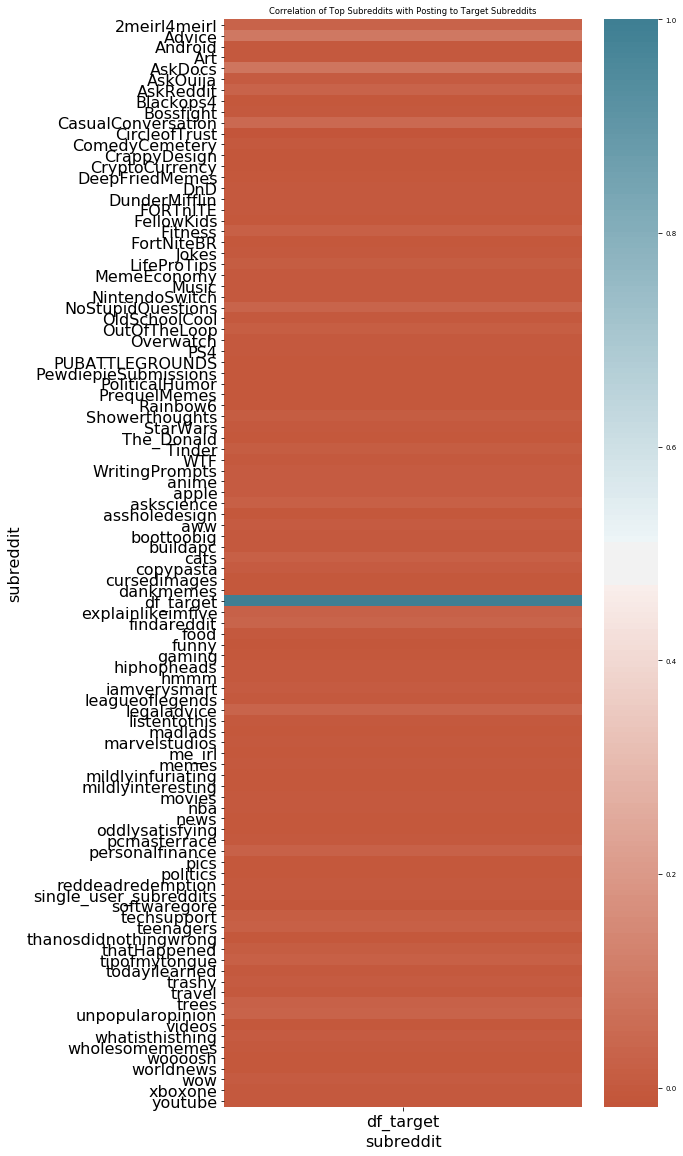

In [276]:
# Overall correlation is low with the target variable for the majority of top subreddits
# though some increase in correlation with subreddits centred around advice

f, ax = plt.subplots(figsize = (8, 20))
plt.rcParams.update({'font.size': 7})
sns.heatmap(top_pivot.corr()[["df_target"]],cmap=sns.diverging_palette(20, 220, n=200), xticklabels= True, yticklabels= True).set_title("Correlation of Top Subreddits with Posting to Target Subreddits")
plt.show()

In [277]:
top_pivot.corr()[["df_target"]]

subreddit,df_target
subreddit,
2meirl4meirl,0.028903
Advice,0.094318
Android,-0.001625
Art,0.000442
AskDocs,0.085297
...,...
woooosh,-0.005775
worldnews,-0.003227
wow,0.002852


In [278]:
# delete for memory
del top_pivot
del df

## Top Reddits for Target Variable 

In [ ]:
graph for each 

#### Create Sparse Dataframe
* Data is far to large to convert into normal dataframe
* Requires creation of a sparse pivot, authors for rows, subreddits for columns & number of posts as variable

In [279]:
df = pd.read_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_DataFinal.csv'")

In [280]:
#set index to unnamed
df.drop("Unnamed: 0", axis= 1, inplace= True)

In [281]:
# creating unique list of subreddits with target as the last value for ease of data manipulation
unique_subs = list(df["subreddit"].unique())
unique_subs.remove("df_target")
unique_subs.append("df_target")

In [282]:
# data is to large for a pandas pivot table, creating a function to create a sparse version 

def create_sparse_pivot(rows, cols, data, values):
    ### function creates a sparse pivot table from large datasets
    r = CategoricalDtype(sorted(data[rows].unique()), ordered=True)
    c = CategoricalDtype(unique_subs)

    row = data[rows].astype(r).cat.codes
    col = data[cols].astype(c).cat.codes
    sparse_matrix = csr_matrix((df[values], (row, col)), \
                           shape=(r.categories.size, c.categories.size))
    
    return sparse_matrix, col


In [283]:
# create sparse df & column references
sparse_df, df_refr = create_sparse_pivot("author", "subreddit", df, "posts")

In [284]:
sample_df.shape

(100000, 51854)

In [285]:
# baseline of 97%, high chance of overestimating the non-MH class
baseline = pd.DataFrame(sparse_df[:, -1].todense())[0].value_counts(normalize= True)
baseline

0.000000   0.949768
1.000000   0.050232
Name: 0, dtype: float64

In [286]:
# create sample dataframe for proof of concept modelling
sample_df = resample(sparse_df, n_samples = 100000, random_state = 13)

In [287]:
# baseline of 97%, high chance of overestimating the non-MH class- similar to the main sample
baseline = pd.DataFrame(sample_df[:, -1].todense())[0].value_counts(normalize= True)
baseline

0.000000   0.950340
1.000000   0.049660
Name: 0, dtype: float64